Analysis of Google stock

Data collected from 'https://finance.yahoo.com/quote/GOOGL/history?p=GOOGL', from 2017 to end of 2022.

In [35]:
# Data processing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Statistics used in analysis
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

# Model and measure metrics
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [36]:
goog = pd.read_csv('../datasets/GOOG.csv')

In [37]:
goog.Date = pd.to_datetime(goog['Date'])
goog = goog.set_index('Date')

goog.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1510 entries, 2017-01-03 to 2022-12-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1510 non-null   float64
 1   High       1510 non-null   float64
 2   Low        1510 non-null   float64
 3   Close      1510 non-null   float64
 4   Adj Close  1510 non-null   float64
 5   Volume     1510 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 82.6 KB


In [38]:
goog.shape

(1510, 6)

In [39]:
goog.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-03,38.940498,39.481499,38.790001,39.306999,39.306999,33146000
2017-01-04,39.417999,39.567001,39.158001,39.345001,39.345001,21460000
2017-01-05,39.304001,39.723999,39.250999,39.701000,39.701000,26704000
2017-01-06,39.763000,40.395000,39.610199,40.307499,40.307499,32804000
2017-01-09,40.320000,40.498299,40.141499,40.332500,40.332500,25492000


In [40]:
goog.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1510.000000,1510.000000,1510.000000,1510.000000,1510.000000,1.510000e+03
mean,79.306040,80.162419,78.489687,79.337876,79.337876,3.073554e+07
std,32.229300,32.592655,31.841737,32.200557,32.200557,1.338655e+07
min,38.940498,39.481499,38.790001,39.306999,39.306999,6.936000e+06
25%,54.179001,54.727437,53.610687,54.157625,54.157625,2.216500e+07
50%,64.674000,65.253246,64.087502,64.765499,64.765499,2.727390e+07
75%,104.174875,105.740997,103.271124,104.766373,104.766373,3.479412e+07
max,151.863495,152.100006,149.887497,150.709000,150.709000,1.241400e+08


No difference between Close and Adj Close. Will drop close and rename adj close to close.

In [41]:
goog[((goog.Close - goog['Adj Close']) < 0) | ((goog.Close - goog['Adj Close'])) > 0].count()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [42]:
goog = goog.drop(['Close'], axis='columns')
goog = goog.rename(columns={'Adj Close': 'Close'})
goog.head()

,Open,High,Low,Close,Volume
Date,,,,,
2017-01-03,38.940498,39.481499,38.790001,39.306999,33146000
2017-01-04,39.417999,39.567001,39.158001,39.345001,21460000
2017-01-05,39.304001,39.723999,39.250999,39.701000,26704000
2017-01-06,39.763000,40.395000,39.610199,40.307499,32804000
2017-01-09,40.320000,40.498299,40.141499,40.332500,25492000


Lets have a look at the time series plot for each variable in goog dataset.

Can see very similar graphs for each of its price variables which makes sense as its unlikely to change majorly during the course of one day.

Can probaly select one price variable as the target variable since they are so close. High might not be a good idea as the high point could be at any point during the day, i.e the close and open are constant everyday times, so predicting the open or close price may be more useful in application.

<Axes: xlabel='Date'>

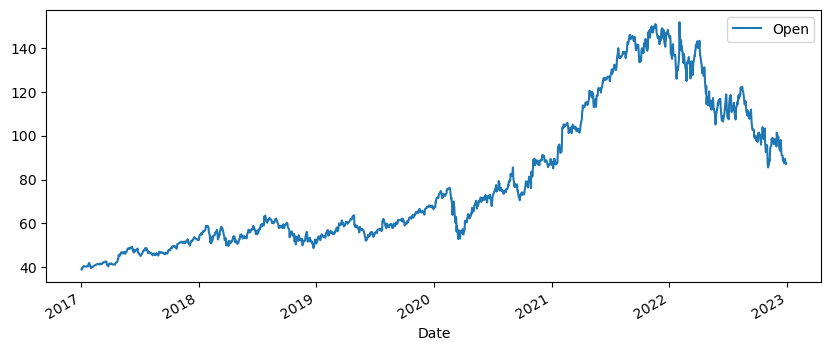

In [43]:
goog['Open'].plot(legend=True, figsize=(10,4))

<Axes: xlabel='Date'>

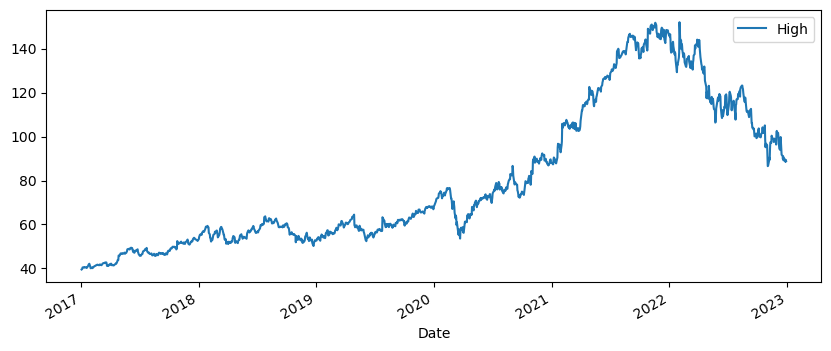

In [44]:
goog['High'].plot(legend=True, figsize=(10,4))

<Axes: xlabel='Date'>

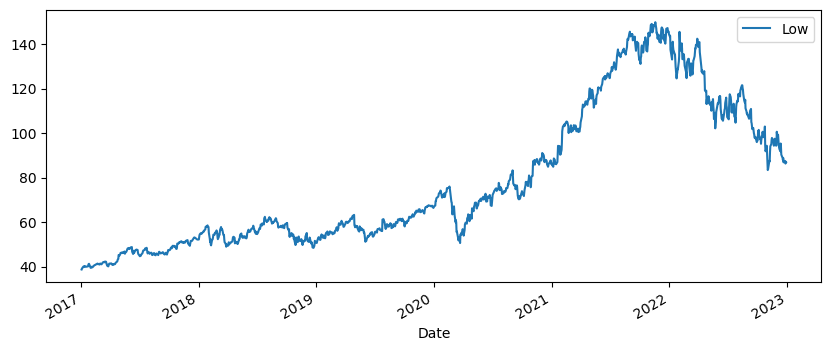

In [45]:
goog['Low'].plot(legend=True, figsize=(10,4))

<Axes: xlabel='Date'>

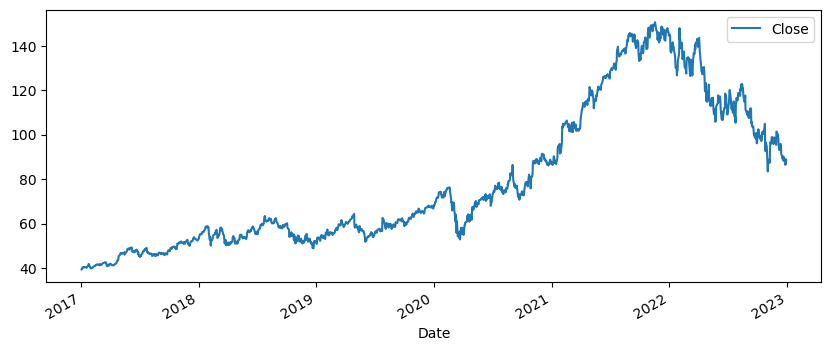

In [46]:
goog['Close'].plot(legend=True, figsize=(10,4))

Seems to be seasonal

<Axes: xlabel='Date'>

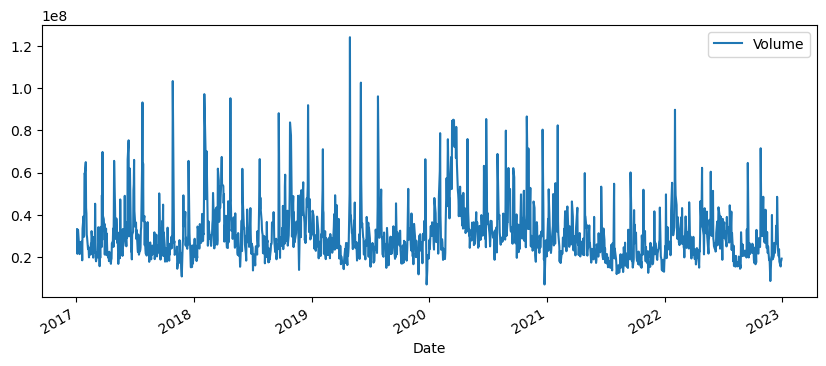

In [47]:
goog['Volume'].plot(legend=True, figsize=(10,4))

Can see verification that one price variable would be better as they all seem t be highly correlated with each other, which makes sense cause they all depend on each other.

In [48]:
goog.corr()

,Open,High,Low,Close,Volume
Open,1.000000,0.999675,0.999640,0.999229,-0.198632
High,0.999675,1.000000,0.999551,0.999627,-0.192529
Low,0.999640,0.999551,1.000000,0.999660,-0.208723
Close,0.999229,0.999627,0.999660,1.000000,-0.201954
Volume,-0.198632,-0.192529,-0.208723,-0.201954,1.000000


Closer look at closing price

In [49]:
goog_close = goog.Close

Can see the distribution of google closing price is normal, skewed to the right.

<Axes: >

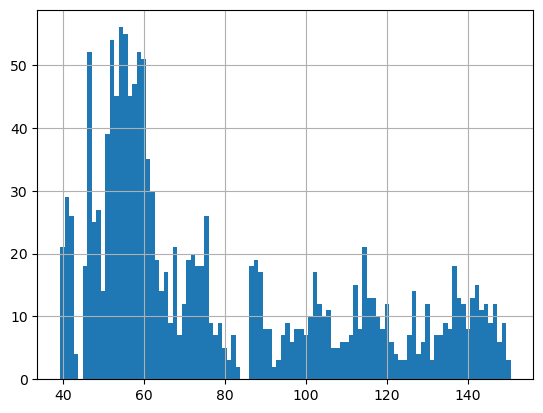

In [50]:
goog_close.hist(bins = 100)

Daily return analysis

Going to look at changes in close price for google. Daily returns can help see how volitile the stock is and help access risk. 

Can see close price daily change is between -10% and +10%. Can see the average return is +0.7%. The standerd deviation is small at +1.8% meaning the stock is not very volatile. 

<Axes: xlabel='Date'>

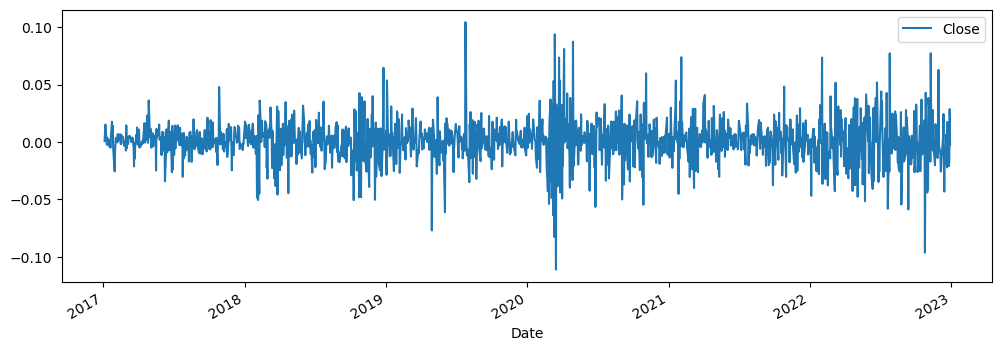

In [51]:
change = goog_close.pct_change()
change.plot(figsize=(12,4), legend=True)

In [52]:
change.describe()

count    1509.000000
mean        0.000710
std         0.018465
min        -0.111008
25%        -0.006923
50%         0.001135
75%         0.009323
max         0.104485
Name: Close, dtype: float64

Can see the daily returns are normally distributed with mean of about +0.7%.

<Axes: >

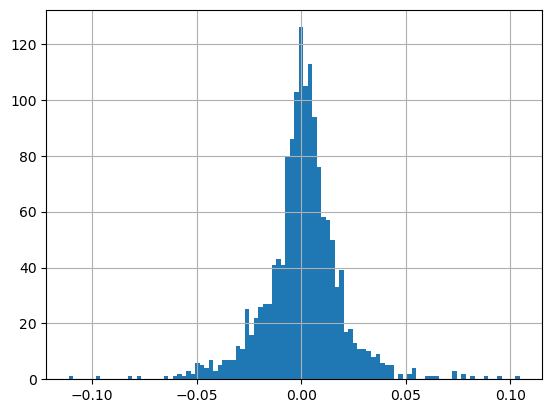

In [53]:
change.hist(bins=100)

Going to get moving averages of 5,10,15,20 days for closing data to see how recent values effect the current value, i.e look for trends. Can see not much change over any of the rolling means with the original price. This hints at maybe no stationarity.

In [54]:
ma_vals = [5, 10, 15, 20]
rolling_means = []
rolling_stds = []
for i in range(0,4):
    rolling_means.append(goog_close.rolling(ma_vals[i]).mean())
    rolling_stds.append(goog_close.rolling(ma_vals[i]).std())


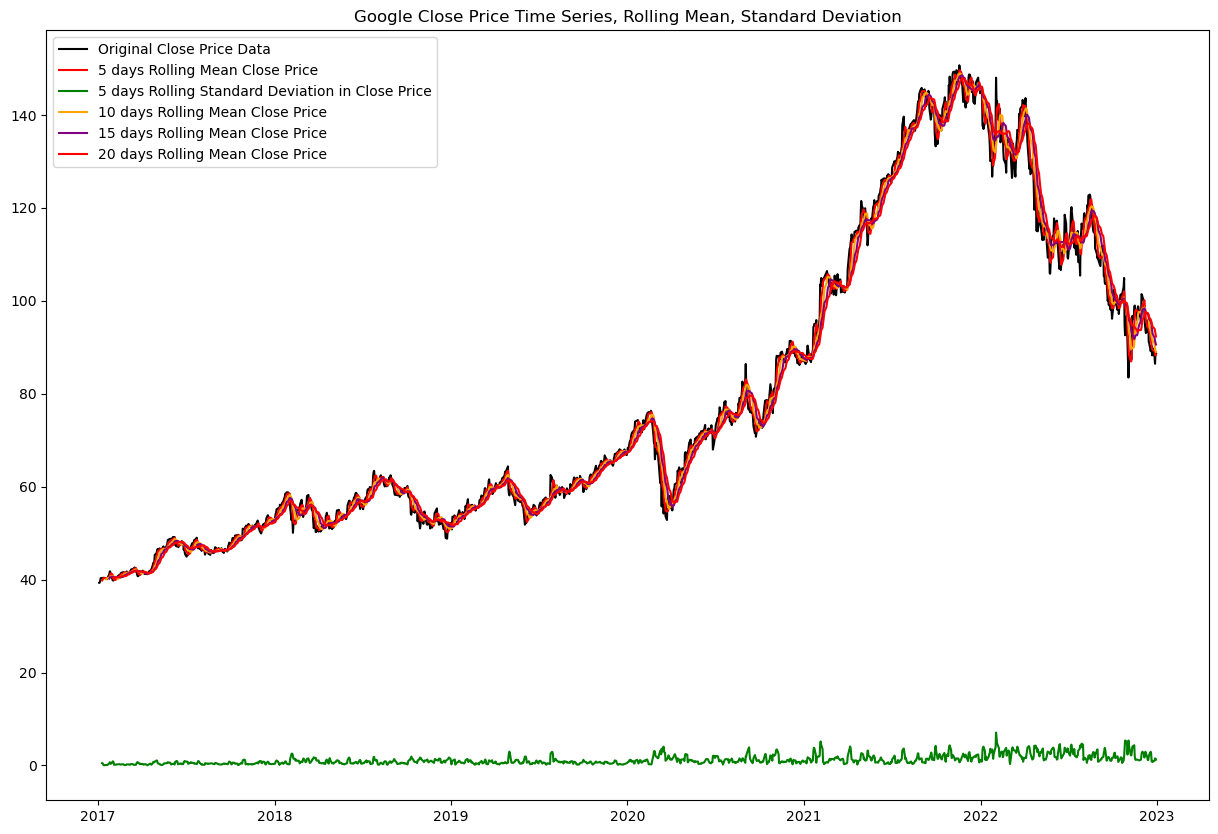

In [55]:
plt.figure(figsize=(15, 10))

plt.plot(goog_close, color="black",label="Original Close Price Data")

plt.plot(rolling_means[0], color="red", label="5 days Rolling Mean Close Price")
plt.plot(rolling_stds[0], color="green", label = "5 days Rolling Standard Deviation in Close Price")
plt.plot(rolling_means[1], color="orange", label="10 days Rolling Mean Close Price")
plt.plot(rolling_means[2], color="purple", label="15 days Rolling Mean Close Price")
plt.plot(rolling_means[3], color="red", label="20 days Rolling Mean Close Price")

plt.title("Google Close Price Time Series, Rolling Mean, Standard Deviation")
plt.legend(loc="best")

plt.show()

The Autocorrelation plot displays the relationship between a term and its own lag on the x-axis. Can observe a number of points from the autocorrelation plot below:

1. Can clearly see google close price is not white noise as most correlation measurements at lag k are distant to zero.
2. Can see the ACF decays up to lag 1000, indicating the upward trend seen above.
3. Can then see the ACF increases after lag 1000, showing the downward trend seen.
4. Closing prices seem to be highly correlated to closing prices seen in previous 100 days.
5. No repeated spikes in ACF which indicates no seasonality.

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

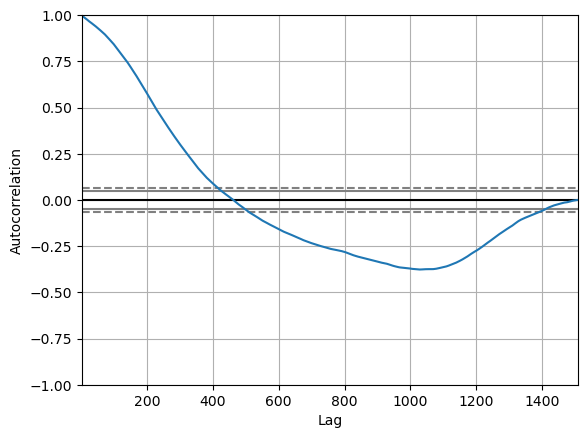

In [56]:
pd.plotting.autocorrelation_plot(goog_close)

Stationarity of google closing price:

Time series data must be made stationary to remove any obvious correlation and collinearity with the past data, for autoregressive models (similar to regression models) to work. In stationary time-series data, the properties or value of a sample observation does not depend on the timestamp at which it is observed

Going to use an augmented Dickey Fuller test to check if google closing price is stationary. Stationarity means that the manner in which time series data changes is constant. A stationary time series will not have any trends or seasonal patterns. ADF tests the null hypothesis that a unit root is present in a time series sample. Unit root is a characteristic of a time series that makes it non-stationary

Can see below as p-value is greater then 

In [57]:

def checkStationary(df):
    adftest = adfuller(df)
    print("ADF Test Results")
    print("Null Hypothesis: The series has a unit root (non-stationary)")
    print("ADF-Statistic:", adftest[0])
    print("P-Value:", adftest[1])
    print("Number of lags:", adftest[2])
    print("Number of observations:", adftest[3])
    print("Critical Values:", adftest[4])
    print("Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary")
checkStationary(goog['Close'])

ADF Test Results
Null Hypothesis: The series has a unit root (non-stationary)
ADF-Statistic: -1.2457488484360337
P-Value: 0.6536128169351245
Number of lags: 9
Number of observations: 1500
Critical Values: {'1%': -3.4347170173134813, '5%': -2.8634687603081486, '10%': -2.5677968484444444}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


Can see the trend going up then slightly down. The error seems to always be near 1.

<Figure size 640x480 with 0 Axes>

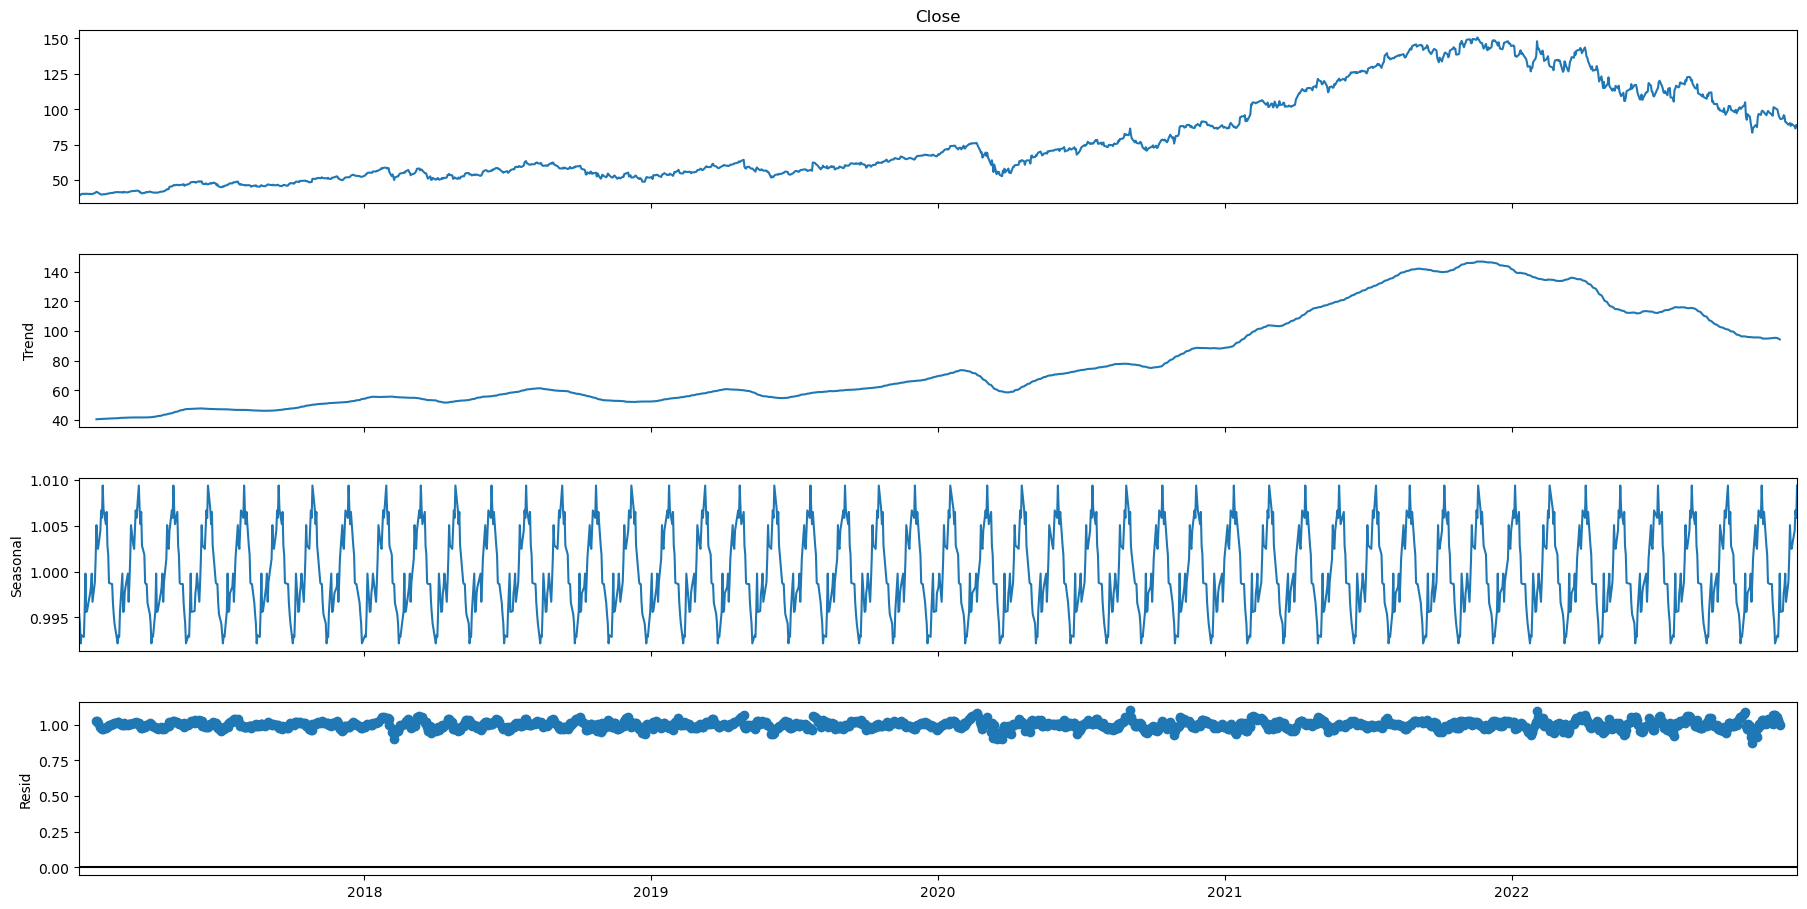

In [58]:
decomposition = seasonal_decompose(goog_close, model='multiplicative', period=31)
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(20, 10)

let goog_close at time t be Yt. Yt' = Yt-Yt-1. Where Yt' is the value of goog_close_diff at time t.

Can see by ADF test that goog_close_diff is stationary. 

In [59]:
goog_close_diff = goog['Close'].diff().dropna()
checkStationary(goog_close_diff)

ADF Test Results
Null Hypothesis: The series has a unit root (non-stationary)
ADF-Statistic: -13.494621889893388
P-Value: 3.058957849827095e-25
Number of lags: 8
Number of observations: 1500
Critical Values: {'1%': -3.4347170173134813, '5%': -2.8634687603081486, '10%': -2.5677968484444444}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


<Axes: xlabel='Date'>

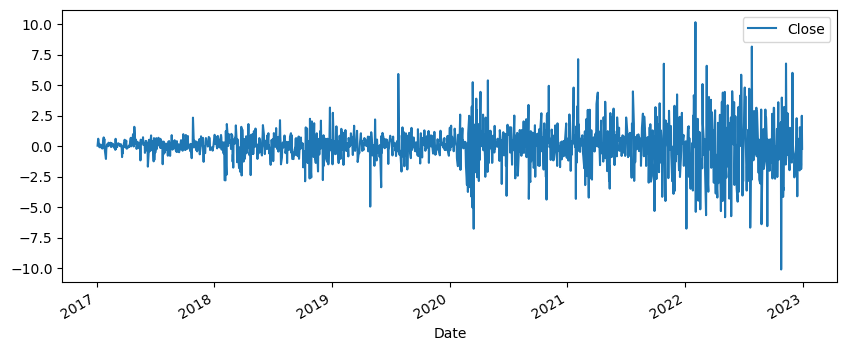

In [60]:
goog_close_diff.plot(legend=True, figsize=(10,4))

ARIMA model to forcast closing price

Will use ARIMA model as a baseline for future modelling. Similar to starting with simple linear regression for a regression problem.

As the past values in the google close price data affect the current or future values and can be used to foretell future trends based on recent fluctuations, I will try use the ARIMA model. As no very obvious seasonal componenet I will use non seasonal ARIMA model.

Since ARIMA models are suitable for short to medium-term forecasting and might not be the best choice for very long-distance forecasting, I will make the test set relativly small, about 3 months.

In [61]:
train = goog_close.loc[:'2022-09-30']
test = goog_close.loc['2022-10-01':]

Choosing arima p, d, q parameters:
AR: p = order of the autoregressive part
I: d = degree of first differencing involved
MA: q = order of the moving average part.

As we have seen previously a difference of 1 on the google close price gives a stationary time series, thus the order of difference (d) is 1.

Can see autocorrelations low i.e data is stationary and not dependent on time. 

Can see from partial autocorrelation plot of the 1st differenced data that the first lag is the most signifigant so p=1.

Can see a similar result by looking at the autocorrelation plot for q. Looking at the number of lags crossing the threshold, we can determine how much of the past would be significant enough to consider for the future. The first lag is a signifigant spike then sharp cutoff at lag 2, so q=1 also.

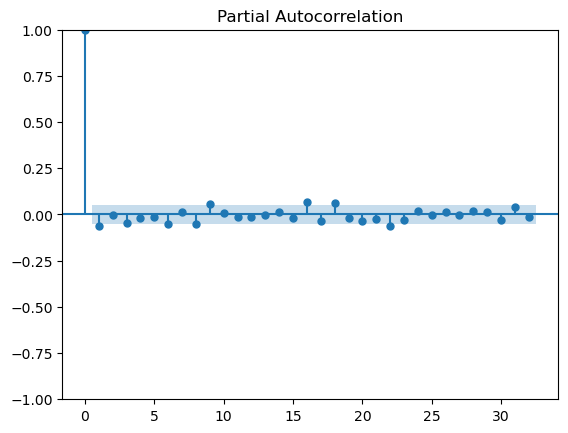

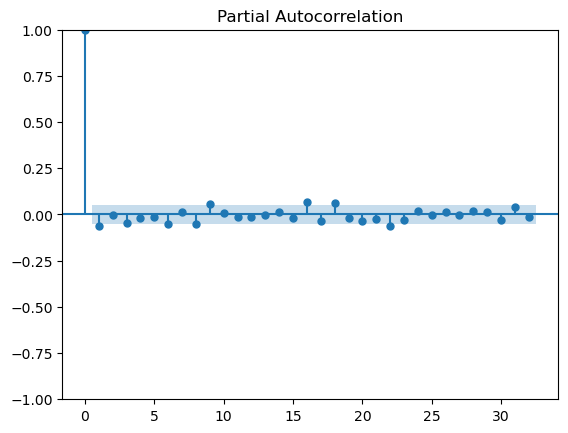

In [62]:
plot_pacf(goog_close_diff)

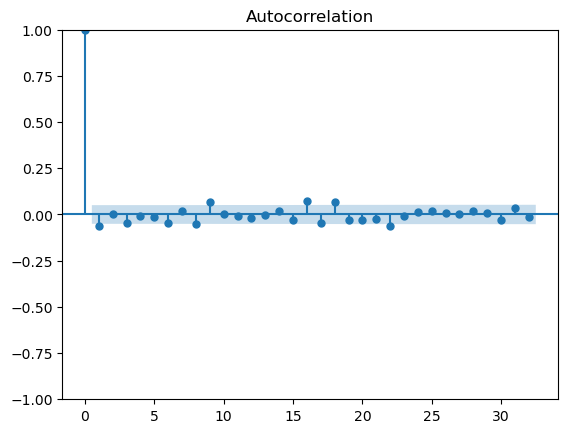

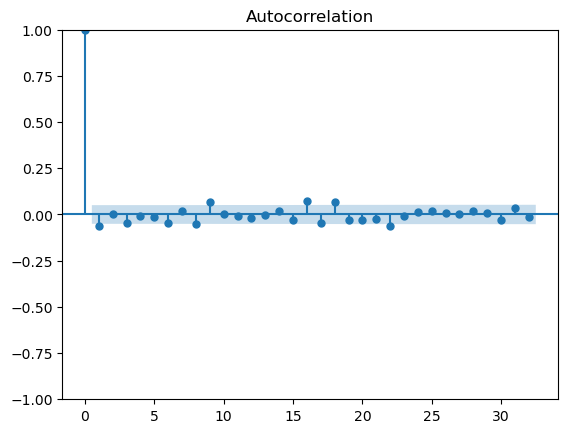

In [63]:
plot_acf(goog_close_diff)

Can verify values for p,d,q with the auto_arima function from pmdarima library. This takes the training data and tests different values of p and q using Akaike's Information Criterion (AIC) as a statistical measure used to assess the goodness of fit of the resulting model. Lower AIC values indicate a better model fit and greater simplicity.

AIC = −2 log(L) + 2(p + q + 1),
where L is the likelihood of the data.

In [64]:
model = pm.auto_arima(train, start_p=0, start_q=0,
              test='adf',
              max_p=10,max_q=10,
              d=1,
              trace=True,
              error_action='ignore',
              suppress_warnings=True,
              stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5387.354, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5381.148, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5381.503, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5386.276, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5382.315, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5381.084, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5383.076, Time=0.25 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5383.074, Time=0.26 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5382.825, Time=0.14 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5382.495, Time=0.39 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=5380.110, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=5380.585, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=5380.224, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=5382.096, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0]          

Here i create the ARIMA model from stats_models package with the p,d,q optimal order I showed earlier and fit it with the training data.

Can see from the summary the AIC is quite high which suggests the model is not greatly fit.

In [65]:
arima_model = ARIMA(train, order=(1,1,1))

model = arima_model.fit()
model.summary()

/home/brian/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/brian/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/brian/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1447
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2687.055
Date:                Thu, 16 Nov 2023   AIC                           5380.110
Time:                        16:53:32   BIC                           5395.940
Sample:                             0   HQIC                          5386.018
                               - 1447                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5058      0.159     -3.176      0.001      -0.818      -0.194
ma.L1          0.4334      0.166      2.607      0.009       0.108       0.759
sigma2         2.4076      0.048     49.953      0.000       2.313       2.502
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1455.27
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               9.19   Skew:                             0.00
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Need to change the index of the forecast to the index of the test data.

In [66]:
test_date_range = pd.date_range(start='2022-10-03',
                                end='2022-12-30',
                                freq='B')[:63]
test.shape
fc = model.forecast(63)

fc.index = test_date_range

/home/brian/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/brian/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Can see forecast is approximatly a horizontel line, so the model has predicted a lot of volatility in the price jumps resulting in a horizontel line.

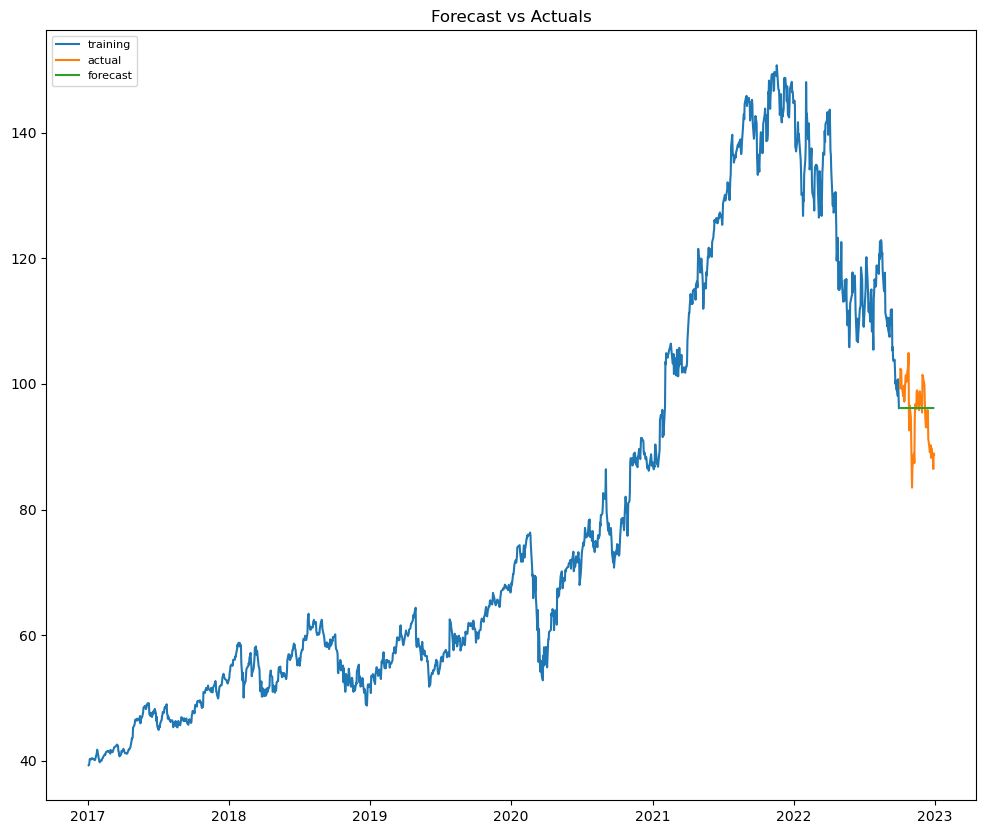

In [67]:
plt.figure(figsize=(12,10), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc, label='forecast')

plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

1. MAE represents the average absolute difference between the predicted and actual values. The MAE of approximately 4.25 suggests that, on average, the model's predictions are off by about 4.25 units from the actual values. 
2. MSE calculates the average of the squared differences between predicted and actual values. The MSE of approximately 26.50 means that, on average, the squared differences between predictions and actual values are around 26.50. Squaring the errors gives more weight to larger errors. As a result, MSE can be more sensitive to outliers. 
3. RMSE is the square root of the MSE and represents the typical error between predicted and actual values. The RMSE of approximately 5.15 indicates that, on average, the model's predictions differ from the actual values by about 5.15 units.

In [68]:
def measure(y, pred):
    print(f'MAE: {mean_absolute_error(y_true=y,y_pred=pred)}')
    print(f"MSE: {mean_squared_error(y_true=y,y_pred=pred)}")
    print(f"RMSE: {mean_squared_error(y_true=y,y_pred=pred,squared=False)}")
measure(test,fc)

MAE: 4.247077533087277
MSE: 26.504072880372142
RMSE: 5.1482106484070895


ARIMA Model conclusion:

ARIMA probably not suitable for google stock data.